In [ ]:
!pip install git+https://github.com/macrosynergy/macrosynergy@develop

  Cloning https://github.com/macrosynergy/macrosynergy (to revision develop) to /tmp/pip-req-build-e29eqj9_
  Running command git clone --filter=blob:none --quiet https://github.com/macrosynergy/macrosynergy /tmp/pip-req-build-e29eqj9_
  Resolved https://github.com/macrosynergy/macrosynergy to commit 2f284af8abe8d19af078f870b80a33eefaaa9160
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 2.0 MB/s eta 0:00:00
  Created wheel for macrosynergy: filename=macrosynergy-0.0.51.dev0+20231207211200.2f284af-py3-none-any.whl size=217428 sha256=bfe50eb45e02aeb319d46c338a557f344b27f07da273a13612e636c36390f5ac
  Stored in directory: /tmp/pip-ephem-wheel-cache-u429auv_/wheels/42/8e/1b/3720977af11deed4a4fc44597ff1223046d9e28a47c91bb946
Successfully built macrosynergy
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.12.2
    Uninst

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

import macrosynergy.management as msm
import macrosynergy.panel as msp
import macrosynergy.signal as mss
import macrosynergy.pnl as msn


from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math


'\nfor dirname, _, filenames in os.walk(\'/kaggle/input\'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n\nimport warnings\n\nwarnings.simplefilter("ignore")\n'

In [ ]:
# Cross-sections of interest

cids_dm = ["AUD", "CAD", "CHF", "EUR", "GBP", "JPY", "NOK", "NZD", "SEK", "USD"]
cids_em = [
    "CLP",
    "COP",
    "CZK",
    "HUF",
    "IDR",
    "ILS",
    "INR",
    "KRW",
    "MXN",
    "PLN",
    "THB",
    "TRY",
    "TWD",
    "ZAR",
]
cids = cids_dm + cids_em
cids_du = cids_dm + cids_em
cids_dux = list(set(cids_du) - set(["IDR", "NZD"]))
cids_xg2 = list(set(cids_dux) - set(["EUR", "USD"]))

In [ ]:
# Quantamental categories of interest

ecos = [
    "CPIC_SA_P1M1ML12",
    "CPIC_SJA_P3M3ML3AR",
    "CPIC_SJA_P6M6ML6AR",
    "CPIH_SA_P1M1ML12",
    "CPIH_SJA_P3M3ML3AR",
    "CPIH_SJA_P6M6ML6AR",
    "INFTEFF_NSA",
    "INTRGDP_NSA_P1M1ML12_3MMA",
    "INTRGDPv5Y_NSA_P1M1ML12_3MMA",
    "PCREDITGDP_SJA_D1M1ML12",
    "PCREDITBN_SJA_P1M1ML12",
    "RGDP_SA_P1Q1QL4_20QMA",
    "RYLDIRS02Y_NSA",
    "RYLDIRS05Y_NSA",
]
mkts = [
    "DU02YXR_NSA",
    "DU05YXR_NSA",
    "DU02YXR_VT10",
    "DU05YXR_VT10",
    "EQXR_NSA",
    "EQXR_VT10",
    "FXXR_NSA",
    "FXXR_VT10",
    "FXCRR_NSA",
    "FXTARGETED_NSA",
    "FXUNTRADABLE_NSA",
]

xcats = ecos + mkts

In [ ]:
# load the dataset:

df = pd.read_csv('JPMaQS_Quantamental_Indicators.csv', index_col=0, parse_dates=['real_date'])

scols = ["cid", "xcat", "real_date", "value"]  # required columns
df = df[scols].copy()
display (df.tail(3))
df.info()

,cid,xcat,real_date,value
209464,CLP,FXXR_VT10,2002-01-02,-0.133823
209465,CLP,INFTEFF_NSA,2002-01-02,3.095981
209466,CLP,INTRGDP_,2002-01-02,NaN


<class 'pandas.core.frame.DataFrame'>
Int64Index: 209467 entries, 0 to 209466
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   cid        209467 non-null  object        
 1   xcat       209467 non-null  object        
 2   real_date  209467 non-null  datetime64[ns]
 3   value      209466 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 8.0+ MB


In [ ]:
display(df['xcat'].unique())
display(df['cid'].unique())
df['ticker'] = df['cid'] + "_" + df["xcat"]
df.set_index('real_date', inplace=True)
df.sort_index(inplace=True)

array(['CPIC_SA_P1M1ML12', 'CPIC_SJA_P3M3ML3AR', 'CPIC_SJA_P6M6ML6AR',
       'CPIH_SA_P1M1ML12', 'CPIH_SJA_P3M3ML3AR', 'CPIH_SJA_P6M6ML6AR',
       'FXTARGETED_NSA', 'FXUNTRADABLE_NSA', 'FXXR_NSA', 'FXXR_VT10',
       'INFTEFF_NSA', 'INTRGDP_NSA_P1M1ML12_3MMA',
       'INTRGDPv5Y_NSA_P1M1ML12_3MMA', 'PCREDITBN_SJA_P1M1ML12',
       'PCREDITGDP_SJA_D1M1ML12', 'RGDP_SA_P1Q1QL4_20QMA',
       'RYLDIRS02Y_NSA', 'RYLDIRS05Y_NSA', 'DU02YXR_NSA', 'DU02YXR_VT10',
       'DU05YXR_NSA', 'DU05YXR_VT10', 'EQXR_NSA', 'EQXR_VT10',
       'FXCRR_NSA', 'INTRGDP_'], dtype=object)

array(['AUD', 'CAD', 'CHF', 'CLP', 'COP', 'CZK', 'EUR', 'GBP', 'HUF',
       'IDR', 'ILS', 'INR', 'JPY', 'KRW', 'MXN', 'NOK', 'NZD', 'PLN',
       'SEK', 'THB', 'TRY', 'TWD', 'USD', 'ZAR'], dtype=object)

#ARIMA

In [ ]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.0 MB/s eta 0:00:00


In [ ]:
dev_y = development_set['DU05YXR_VT10']
test_y = test_set['DU05YXR_VT10']
val_y = val_set['DU05YXR_VT10']

In [ ]:
model_autoARIMA = auto_arima(dev_y, start_p=0, start_q=0,
                      test='adf',       # use adftest to find  optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=671.171, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=666.442, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=666.672, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=668.438, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=668.440, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=670.320, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=665.818, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=669.528, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=667.751, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=667.789, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=665.887, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=668.987, Time=0.16 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.709 seconds
                               SARIMAX Results                                
Dep. Variable:       

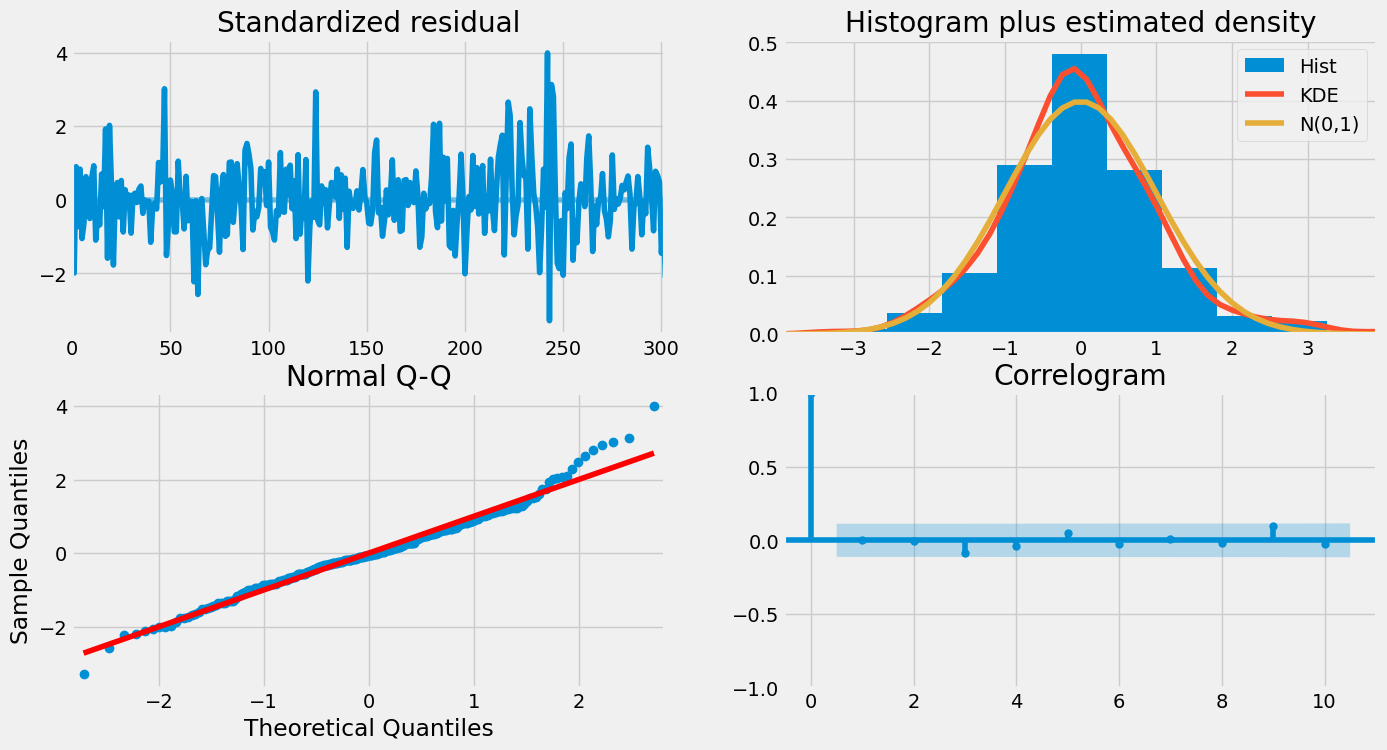

In [ ]:
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [ ]:
model = ARIMA(dev_y, order=(1, 0, 0))


In [ ]:
fitted = model.fit()
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:           DU05YXR_VT10   No. Observations:                  303
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -329.909
Date:                Fri, 08 Dec 2023   AIC                            665.818
Time:                        01:47:25   BIC                            676.960
Sample:                             0   HQIC                           670.276
                                - 303                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0783      0.050      1.581      0.114      -0.019       0.175
ar.L1          0.1381      0.043      3.241      0.001       0.055       0.222
sigma2         0.5167      0.034     15.255      0.0

In [ ]:
# Forecast
fc= fitted.forecast(544, alpha=0.05)  # 95% confidence
fc_series = pd.Series(fc, index=test_y.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(test_y, color = 'blue', label='Actual ')
plt.plot(fc_series, color = 'orange',label='Predicted ')
plt.title('Prediction')
plt.xlabel('Time')
plt.ylabel('Actual')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
print("MSE: ", mean_squared_error(test_y, fc_series).numpy())

MSE:  0.8369782179209767
